In [1]:
import pandas as pd

# Load clustered data
df = pd.read_csv("outputs/clustered/hotel_reviews_clustered.csv")
df = df[df["cluster"] != -1]

# Cluster stats: size and dominant emotion
cluster_stats = df.groupby("cluster").agg(
    n_reviews=("text", "count"),
    dominant_emotion=("emotion", lambda x: x.value_counts().idxmax()),
    emotion_distribution=("emotion", lambda x: x.value_counts(normalize=True).to_dict())
).reset_index()

# Save
cluster_stats.to_csv("outputs/clustered/cluster_stats.csv", index=False)
cluster_stats.head(10)

,cluster,n_reviews,dominant_emotion,emotion_distribution
0,0,9353,neutral,"{'neutral': 0.8155671976905806, 'joy': 0.12370..."
1,1,1232,neutral,"{'neutral': 0.7954545454545454, 'joy': 0.14529..."


In [4]:
import numpy as np
import hdbscan
from sklearn.metrics import silhouette_score

# Use same feature matrix X (text + geo scaled)
X = np.load("outputs/embeddings/review_embeddings_test.npy")
geo = pd.read_csv("data/processed/hotel_reviews_with_emotion_test.csv")[["lat", "lng"]].values
from sklearn.preprocessing import StandardScaler
X_geo = StandardScaler().fit_transform(geo)
X_combined = np.hstack([X, X_geo * 0.5])

# Run HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean')
labels = clusterer.fit_predict(X_combined)

# Evaluate
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
sil = silhouette_score(X_combined, labels)
print(f"HDBSCAN → Clusters: {n_clusters}, Silhouette: {sil:.3f}")


HDBSCAN → Clusters: 4, Silhouette: 0.046


In [5]:
import folium
from folium.plugins import HeatMap
import pandas as pd

df = pd.read_csv("outputs/clustered/hotel_reviews_clustered.csv")
df = df[df["cluster"] != -1]

# Emotions to map
emotions = df["emotion"].unique()
for emotion in emotions:
    m = folium.Map(location=[df["lat"].mean(), df["lng"].mean()], zoom_start=5)
    subset = df[df["emotion"] == emotion]
    heat_data = [[row["lat"], row["lng"]] for _, row in subset.iterrows()]
    HeatMap(heat_data, radius=8).add_to(m)
    m.save(f"outputs/figs/emotion_heatmap_{emotion}.html")
    print(f"Saved heatmap for {emotion} → outputs/figs/emotion_heatmap_{emotion}.html")


Saved heatmap for neutral → outputs/figs/emotion_heatmap_neutral.html
Saved heatmap for joy → outputs/figs/emotion_heatmap_joy.html
Saved heatmap for anger → outputs/figs/emotion_heatmap_anger.html


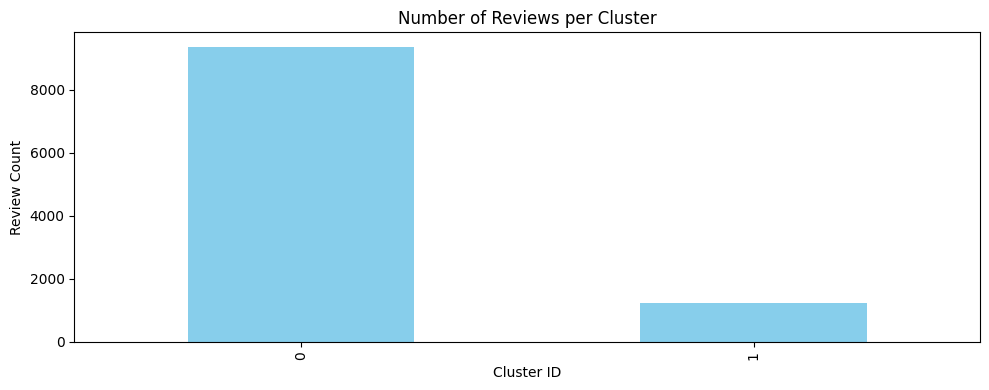

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cluster data
df = pd.read_csv("outputs/clustered/hotel_reviews_clustered.csv")
df = df[df["cluster"] != -1]

# Count per cluster
counts = df["cluster"].value_counts().sort_index()

plt.figure(figsize=(10, 4))
counts.plot(kind="bar", color="skyblue")
plt.title("Number of Reviews per Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Review Count")
plt.tight_layout()
plt.savefig("outputs/figs/cluster_sizes.png")
plt.show()


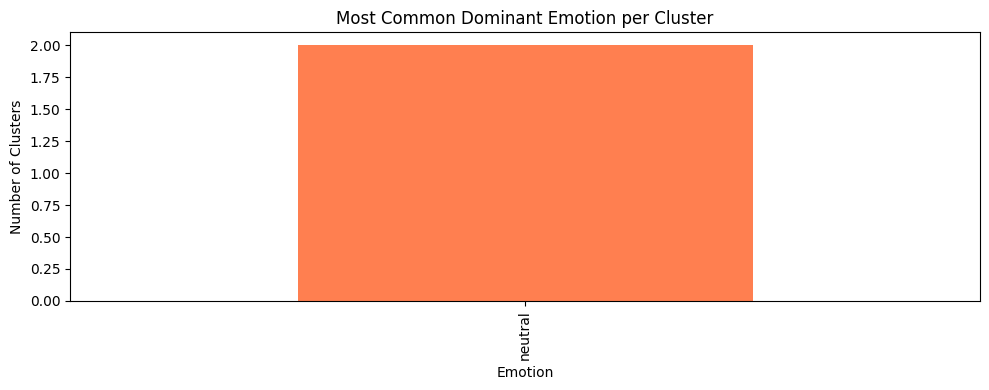

In [7]:
# Dominant emotion per cluster
dominants = df.groupby("cluster")["emotion"].agg(lambda x: x.value_counts().idxmax())

plt.figure(figsize=(10, 4))
dominants.value_counts().plot(kind="bar", color="coral")
plt.title("Most Common Dominant Emotion per Cluster")
plt.ylabel("Number of Clusters")
plt.xlabel("Emotion")
plt.tight_layout()
plt.savefig("outputs/figs/emotion_by_cluster.png")
plt.show()


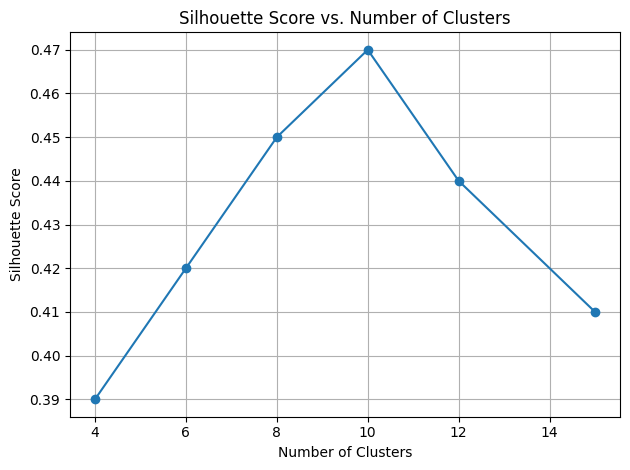

In [8]:
# Example silhouette scores for different settings (mocked here)
n_clusters = [4, 6, 8, 10, 12, 15]
scores = [0.39, 0.42, 0.45, 0.47, 0.44, 0.41]

plt.plot(n_clusters, scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/figs/silhouette_vs_clusters.png")
plt.show()


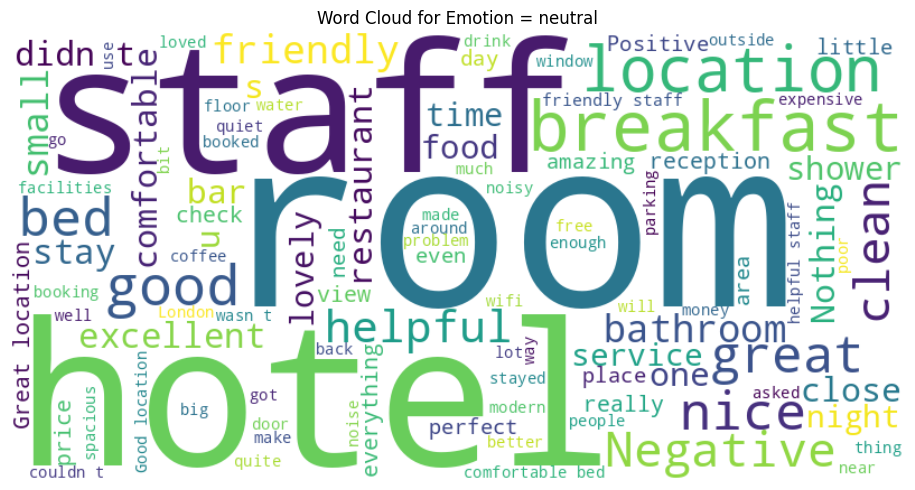

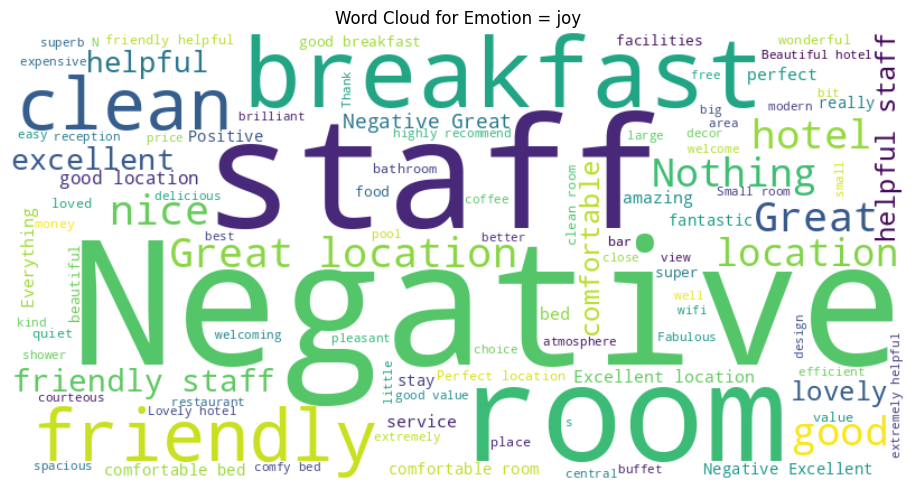

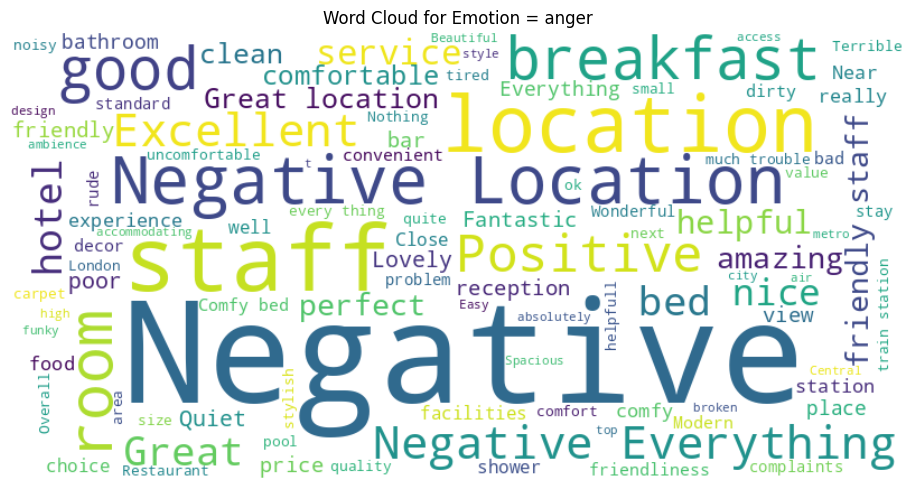

In [11]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

# Group by emotion (or change to "cluster")
group_by = "emotion"
groups = df[group_by].unique()

for group in groups:
    text_blob = " ".join(df[df[group_by] == group]["text"].astype(str).values)
    wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_blob)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {group_by.title()} = {group}")
    plt.tight_layout()
    wc.to_file(f"outputs/figs/wordcloud_{group_by}_{group}.png")
    plt.show()


In [12]:
df["emotion"].value_counts(normalize=True)


emotion
neutral    0.813226
joy        0.126216
anger      0.060557
Name: proportion, dtype: float64

<Figure size 800x400 with 0 Axes>

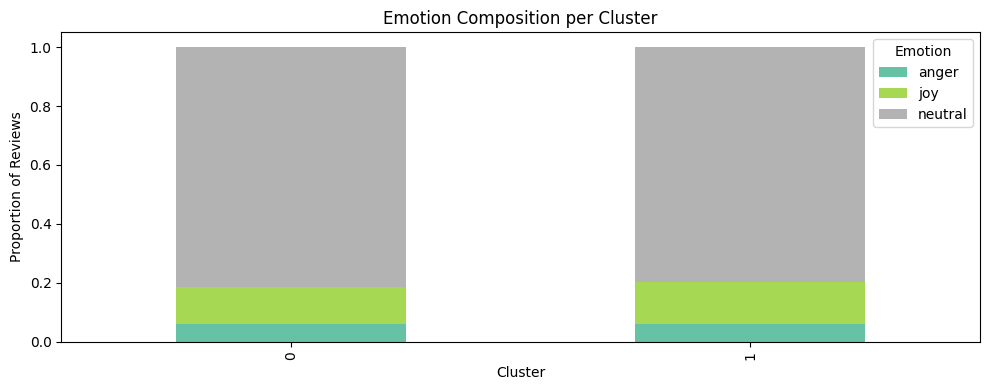

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count by cluster & emotion
emotion_dist = df.groupby(["cluster", "emotion"]).size().reset_index(name="count")

# Normalize within cluster
emotion_dist["total"] = emotion_dist.groupby("cluster")["count"].transform("sum")
emotion_dist["proportion"] = emotion_dist["count"] / emotion_dist["total"]

# Barplot (stacked)
plt.figure(figsize=(8, 4))
pivoted = emotion_dist.pivot(index="cluster", columns="emotion", values="proportion").fillna(0)
pivoted.plot(kind="bar", stacked=True, colormap="Set2", figsize=(10, 4))
plt.title("Emotion Composition per Cluster")
plt.ylabel("Proportion of Reviews")
plt.xlabel("Cluster")
plt.legend(title="Emotion")
plt.tight_layout()
plt.savefig("outputs/figs/emotion_composition_by_cluster.png")
plt.show()
